## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [14]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x  = keras.layers.Dense(units=n_units,
                                    activation='relu',
                                    name = 'hidden_layer' + str(i+1))(input_layer)
            x = BatchNormalization()(x)
            
        else:
            x = keras.layers.Dense(units =n_units,
                                   activation='relu',
                                   name = 'hidden_layer' + str(i+1))(x)
            x = BatchNormalization()(x)
            
    out = keras.layers.Dense(units = output_units, activation='softmax', name = 'output')(x)
    model = keras.models.Model(inputs = [input_layer], outputs = [out])
    return model

In [15]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [19]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy
"""
def combined_loss(ce_weight, gamma = 2., alpha = 4.):
    """Define the customized loss."""
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss(y_true, y_pred):
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return ce_w * tf.reduce_mean(reduced_fl) + (1-ce_w) * (-tf.log(model_out))
    return focal_loss
ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [20]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(ce_w), metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00


W0727 12:01:58.684512 26656 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_10 (Batc (None, 128)               512       
__________

W0727 12:01:58.955408 26656 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0727 12:01:59.512972 26656 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 41s 811us/step - loss: 2.7586 - acc: 0.1055 - val_loss: 2.7809 - val_acc: 0.1069
Epoch 2/25
50000/50000 [==============================] - 15s 301us/step - loss: 2.5080 - acc: 0.0984 - val_loss: 2.5738 - val_acc: 0.0985
Epoch 3/25
50000/50000 [==============================] - 11s 226us/step - loss: 2.4320 - acc: 0.1000 - val_loss: 2.4842 - val_acc: 0.0923
Epoch 4/25
50000/50000 [==============================] - 12s 243us/step - loss: 2.3969 - acc: 0.0999 - val_loss: 2.4316 - val_acc: 0.0916
Epoch 5/25
50000/50000 [==============================] - 15s 290us/step - loss: 2.3767 - acc: 0.0995 - val_loss: 2.4018 - val_acc: 0.0951
Epoch 6/25
50000/50000 [==============================] - 18s 365us/step - loss: 2.3632 - acc: 0.1015 - val_loss: 2.3812 - val_acc: 0.0955
Epoch 7/25
50000/50000 [==============================] - 19s 377us/step - loss: 2.3537 - acc: 0.1014 - val_loss: 2.

50000/50000 [==============================] - 11s 211us/step - loss: 2.9072 - acc: 0.6103 - val_loss: 3.1615 - val_acc: 0.4837
Epoch 24/25
50000/50000 [==============================] - 9s 184us/step - loss: 2.8951 - acc: 0.6162 - val_loss: 3.1697 - val_acc: 0.4799
Epoch 25/25
 1024/50000 [..............................] - ETA: 54s - loss: 2.8667 - acc: 0.6328

C:\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.718036). Check your callbacks.
  % delta_t_median)


 2048/50000 [>.............................] - ETA: 5:22 - loss: 2.8882 - acc: 0.6270

C:\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.361511). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 27s 542us/step - loss: 2.8854 - acc: 0.6225 - val_loss: 3.1614 - val_acc: 0.4817
Numbers of exp: 2, ce_weight: 0.50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_14 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)     

50000/50000 [==============================] - 18s 360us/step - loss: 2.9269 - acc: 0.6174 - val_loss: 3.7177 - val_acc: 0.4834
Epoch 13/25
50000/50000 [==============================] - 12s 247us/step - loss: 2.8575 - acc: 0.6290 - val_loss: 3.7519 - val_acc: 0.4836
Epoch 14/25
50000/50000 [==============================] - 11s 219us/step - loss: 2.7915 - acc: 0.6438 - val_loss: 3.6510 - val_acc: 0.5017
Epoch 15/25
50000/50000 [==============================] - 16s 314us/step - loss: 2.7305 - acc: 0.6553 - val_loss: 3.6846 - val_acc: 0.4938
Epoch 16/25
50000/50000 [==============================] - 17s 342us/step - loss: 2.6750 - acc: 0.6651 - val_loss: 3.6990 - val_acc: 0.4902
Epoch 17/25
50000/50000 [==============================] - 10s 208us/step - loss: 2.6158 - acc: 0.6789 - val_loss: 3.6901 - val_acc: 0.4951
Epoch 18/25
50000/50000 [==============================] - 11s 221us/step - loss: 2.5592 - acc: 0.6914 - val_loss: 3.7594 - val_acc: 0.4857
Epoch 19/25
50000/50000 [=======

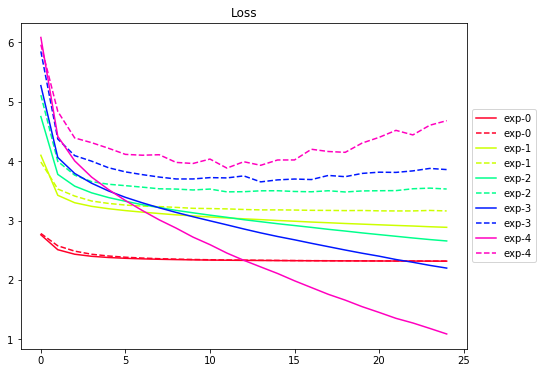

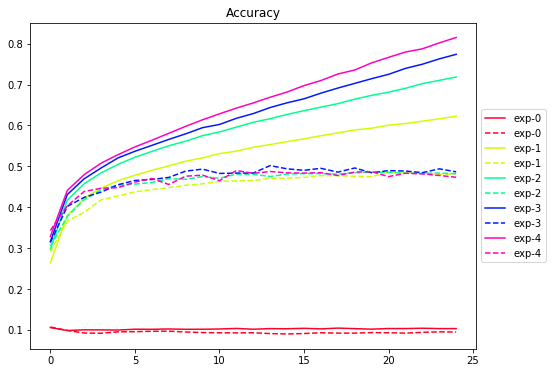

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()